In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams["figure.figsize"] = 8, 5

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

**Первичная подготовка данных: выделение новых признаков, приведение T/F признаков к числовым. Пропуски не заполняются.**

In [2]:
train_csv = pd.read_csv('./data/train.csv')
test_csv = pd.read_csv('./data/test.csv')


def data_preparation(csv):
    df = csv.copy()
    df.drop('Name', axis=1, inplace=True)

    df.loc[:, 'CryoSleep'] = df.loc[:, 'CryoSleep'].map({False: 0, True: 1})

    df.insert(1, 'Group', df['PassengerId'].str.split('_').str.get(0).astype(np.int64))
    group_vc = df['Group'].value_counts()
    df.insert(2, 'SameGroupCount', df['Group'].apply(lambda x: group_vc[x] - 1))
    df.drop('PassengerId', axis=1, inplace=True)

    df.insert(5, 'CabinSideIsPort', df['Cabin'].str.split('/').str.get(2).map({'S': 0, 'P': 1}))
    df.insert(5, 'CabinNum', df['Cabin'].str.split('/').str.get(1).astype('float'))

    df.insert(5, 'CabinDeck', df['Cabin'].str.split('/').str.get(0))
    df.drop('Cabin', axis=1, inplace=True)

    df.loc[:, 'VIP'] = df.loc[:, 'VIP'].map({False: 0, True: 1})

    df.drop('CabinNum', axis=1, inplace=True)

    return df


train_df = data_preparation(train_csv)
train_df.loc[:, 'Transported'] = train_df.loc[:, 'Transported'].map({False: 0, True: 1})
test_df = data_preparation(test_csv)

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Group            8693 non-null   int64  
 1   SameGroupCount   8693 non-null   int64  
 2   HomePlanet       8492 non-null   object 
 3   CryoSleep        8476 non-null   float64
 4   CabinDeck        8494 non-null   object 
 5   CabinSideIsPort  8494 non-null   float64
 6   Destination      8511 non-null   object 
 7   Age              8514 non-null   float64
 8   VIP              8490 non-null   float64
 9   RoomService      8512 non-null   float64
 10  FoodCourt        8510 non-null   float64
 11  ShoppingMall     8485 non-null   float64
 12  Spa              8510 non-null   float64
 13  VRDeck           8505 non-null   float64
 14  Transported      8693 non-null   int64  
dtypes: float64(9), int64(3), object(3)
memory usage: 1018.8+ KB


In [4]:
train_df.describe()

,Group,SameGroupCount,CryoSleep,CabinSideIsPort,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,8693.000000,8693.000000,8476.000000,8494.000000,8514.000000,8490.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,4633.389624,1.035546,0.358306,0.495173,28.827930,0.023439,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624
std,2671.028856,1.596347,0.479531,0.500006,14.489021,0.151303,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2319.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4630.000000,0.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,6883.000000,2.000000,1.000000,1.000000,38.000000,0.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000
max,9280.000000,7.000000,1.000000,1.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


In [5]:
train_df.head(5)

,Group,SameGroupCount,HomePlanet,CryoSleep,CabinDeck,CabinSideIsPort,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,0,Europa,0.0,B,1.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2,0,Earth,0.0,F,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1
2,3,1,Europa,0.0,A,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0
3,3,1,Europa,0.0,A,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0
4,4,0,Earth,0.0,F,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1


In [6]:
test_df.head(5)

,Group,SameGroupCount,HomePlanet,CryoSleep,CabinDeck,CabinSideIsPort,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,13,0,Earth,1.0,G,0.0,TRAPPIST-1e,27.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18,0,Earth,0.0,F,0.0,TRAPPIST-1e,19.0,0.0,0.0,9.0,0.0,2823.0,0.0
2,19,0,Europa,1.0,C,0.0,55 Cancri e,31.0,0.0,0.0,0.0,0.0,0.0,0.0
3,21,0,Europa,0.0,C,0.0,TRAPPIST-1e,38.0,0.0,0.0,6652.0,0.0,181.0,585.0
4,23,0,Earth,0.0,F,0.0,TRAPPIST-1e,20.0,0.0,10.0,0.0,635.0,0.0,0.0


**Среди VIP-пассажиров доля телепортированных значительно меньше**

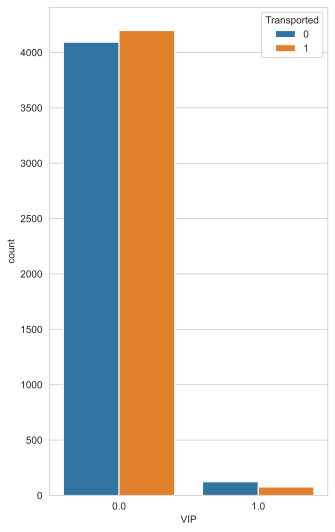

In [7]:
plt.figure(figsize=(5, 9))
sns.countplot(data=train_df, x='VIP', hue='Transported');

Доля пропущенных значений в категориальных признаках

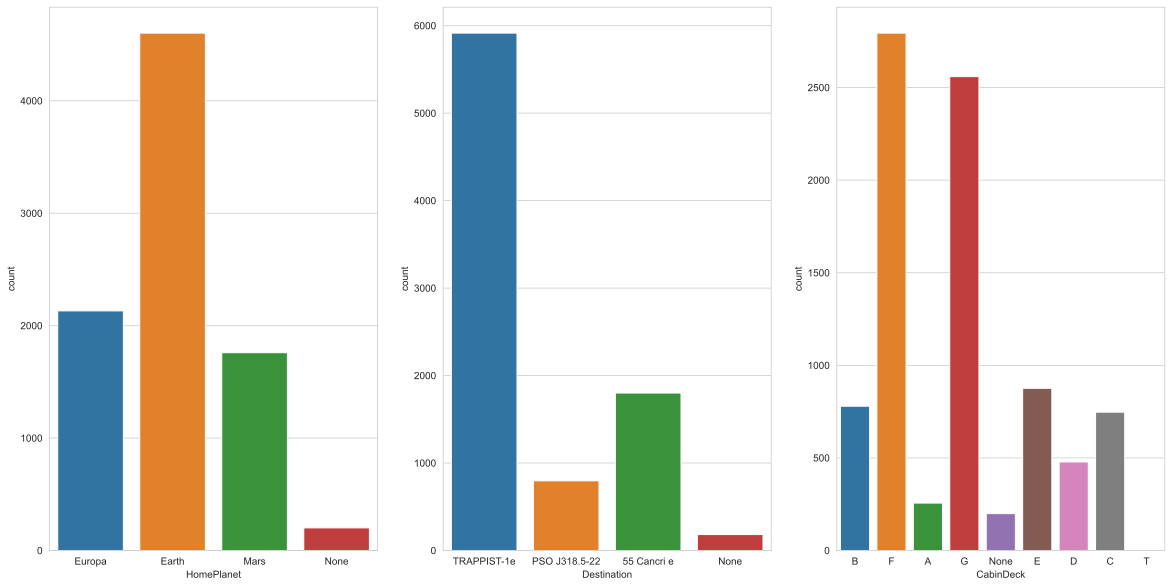

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
sns.countplot(x=train_df['HomePlanet'].fillna('None'), ax=ax[0])
sns.countplot(x=train_df['Destination'].fillna('None'), ax=ax[1])
sns.countplot(x=train_df['CabinDeck'].fillna('None'), ax=ax[2]);

Получение категориальных и числовых колонок

In [9]:
cat_missing_columns = [column for column in train_df.columns if train_df[column].dtype == np.object and train_df[column].count() < train_df.shape[0] and column != 'HomePlanet']
# cat_missing_columns = [column for column in train_df.columns if train_df[column].dtype == np.object and train_df[column].count() < train_df.shape[0]]

num_missing_columns = [column for column in train_df.columns if (train_df[column].dtype == np.float64 or train_df[column].dtype == np.int64) and train_df[column].count() < train_df.shape[0]]
print(cat_missing_columns)
print(num_missing_columns)

['CabinDeck', 'Destination']
['CryoSleep', 'CabinSideIsPort', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


C:\Users\dmit\AppData\Local\Temp\ipykernel_15416\3376705164.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat_missing_columns = [column for column in train_df.columns if train_df[column].dtype == np.object and train_df[column].count() < train_df.shape[0] and column != 'HomePlanet']


**Проверка гипотезы о том, что люди, находящиеся в одной группе, в основном летят с одной планеты**

In [10]:
hp_in_group = train_df.dropna().groupby(by='Group')[['HomePlanet', 'SameGroupCount']].agg({'HomePlanet': [pd.Series.mode, pd.unique], 'SameGroupCount': np.max})
hp_in_group.loc[:, ('HomePlanet', 'unique_count')] = hp_in_group.loc[:, ('HomePlanet', 'unique')].apply(lambda s: s[~pd.isna(s)].size)
hp_in_group

HomePlanet           SameGroupCount   HomePlanet
            mode    unique           amax unique_count
Group                                                 
1         Europa  [Europa]              0            1
2          Earth   [Earth]              0            1
3         Europa  [Europa]              1            1
4          Earth   [Earth]              0            1
5          Earth   [Earth]              0            1
...          ...       ...            ...          ...
9275      Europa  [Europa]              2            1
9276      Europa  [Europa]              0            1
9278       Earth   [Earth]              0            1
9279       Earth   [Earth]              0            1
9280      Europa  [Europa]              1            1

[5111 rows x 4 columns]

In [11]:
(hp_in_group.loc[:, ('HomePlanet', 'unique_count')] == 1).all()

True

**Действительно, пассажиры из одной группы летят с одной планеты**

**Создадим преобразователь, который заполнит пропущенные значения планет планетами людей в этой же группе. Это необходимо для того, чтобы на пайплайне не "подсматривать" в валидационную выборку.**

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class HomePlanetImputer(BaseEstimator, TransformerMixin):
    def __init__(self, copy=True):
        self.copy = copy

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        grouped = grouped = X.groupby(by='Group')['HomePlanet'].agg(pd.Series.mode)
        most_frequent_planet = pd.Series.mode(X['HomePlanet'])[0]
        if self.copy:
            X_copy = X.copy()
            X_copy.loc[X_copy['HomePlanet'].isnull(), 'HomePlanet'] = X_copy.loc[X_copy['HomePlanet'].isnull(), :].apply(lambda s: grouped[s[0]] if type(grouped[s[0]]) is str else most_frequent_planet, axis=1)
            return X_copy
        else:
            X.loc[X['HomePlanet'].isnull(), 'HomePlanet'] = X.loc[X['HomePlanet'].isnull(), :].apply(lambda s: grouped[s[0]] if type(grouped[s[0]]) is str else most_frequent_planet, axis=1)
            return X

Добавляем преобразователь, который в рамках пайплайна из текущих данных сделает датафрейм с заданными именами колонок. Это необходимо потому, что Imputer возвращает не датафрейм, а numpy матрицу, и, следовательно, OHE не может выполнить преобразование

In [13]:
class ColumnSetter(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, *_):
        return self

    def transform(self, X,
                  *_
                  ):
        return pd.DataFrame(X, columns=self.columns)


**Выделим обучающую, валидационную и тестовую выборку**

In [14]:
X_test = test_df.copy()
X_full_train = train_df.iloc[:, :-1].copy()
y_full_train = train_df['Transported'].copy()
X_train, X_valid, y_train, y_valid = train_test_split(X_full_train, y_full_train, test_size=0.3)
X_train

,Group,SameGroupCount,HomePlanet,CryoSleep,CabinDeck,CabinSideIsPort,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
5067,5415,0,Earth,0.0,F,1.0,TRAPPIST-1e,22.0,0.0,0.0,747.0,8.0,0.0,314.0
1448,1529,1,Europa,0.0,A,0.0,PSO J318.5-22,25.0,1.0,0.0,7069.0,0.0,45.0,282.0
3186,3437,1,Earth,0.0,G,0.0,PSO J318.5-22,26.0,0.0,6.0,0.0,400.0,2.0,373.0
6411,6774,2,Earth,1.0,G,1.0,TRAPPIST-1e,45.0,0.0,0.0,0.0,NaN,0.0,0.0
7999,8559,2,Mars,0.0,E,1.0,TRAPPIST-1e,27.0,1.0,3.0,952.0,208.0,951.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5149,5499,0,Earth,1.0,G,0.0,TRAPPIST-1e,40.0,0.0,0.0,0.0,0.0,0.0,0.0
1842,1969,0,Europa,0.0,C,0.0,55 Cancri e,27.0,0.0,NaN,21066.0,0.0,2448.0,2293.0
7184,7676,0,Mars,0.0,D,0.0,TRAPPIST-1e,37.0,1.0,2771.0,0.0,6.0,1.0,10.0
6804,7187,0,Earth,1.0,G,1.0,PSO J318.5-22,28.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
X_valid

,Group,SameGroupCount,HomePlanet,CryoSleep,CabinDeck,CabinSideIsPort,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
7971,8521,0,Europa,0.0,A,0.0,TRAPPIST-1e,41.0,0.0,0.0,0.0,0.0,0.0,0.0
6276,6643,0,Earth,0.0,F,0.0,TRAPPIST-1e,20.0,0.0,0.0,6.0,24.0,0.0,672.0
2096,2243,0,Earth,0.0,G,1.0,TRAPPIST-1e,22.0,0.0,38.0,483.0,80.0,47.0,121.0
3271,3515,1,Mars,1.0,F,1.0,TRAPPIST-1e,37.0,0.0,0.0,0.0,0.0,0.0,0.0
5408,5776,0,Earth,0.0,F,0.0,TRAPPIST-1e,21.0,0.0,0.0,128.0,209.0,4.0,383.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3934,4203,0,Mars,0.0,D,1.0,TRAPPIST-1e,40.0,0.0,0.0,0.0,1.0,293.0,667.0
2776,2995,1,Europa,1.0,B,1.0,55 Cancri e,26.0,0.0,0.0,0.0,0.0,0.0,0.0
5775,6118,1,Mars,0.0,F,1.0,55 Cancri e,42.0,0.0,1156.0,0.0,1.0,305.0,0.0
3112,3353,5,Europa,0.0,C,0.0,TRAPPIST-1e,45.0,0.0,0.0,1897.0,0.0,880.0,605.0


In [16]:
X_test

,Group,SameGroupCount,HomePlanet,CryoSleep,CabinDeck,CabinSideIsPort,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,13,0,Earth,1.0,G,0.0,TRAPPIST-1e,27.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18,0,Earth,0.0,F,0.0,TRAPPIST-1e,19.0,0.0,0.0,9.0,0.0,2823.0,0.0
2,19,0,Europa,1.0,C,0.0,55 Cancri e,31.0,0.0,0.0,0.0,0.0,0.0,0.0
3,21,0,Europa,0.0,C,0.0,TRAPPIST-1e,38.0,0.0,0.0,6652.0,0.0,181.0,585.0
4,23,0,Earth,0.0,F,0.0,TRAPPIST-1e,20.0,0.0,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266,1,Earth,1.0,G,0.0,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,0.0
4273,9269,0,Earth,0.0,NaN,NaN,TRAPPIST-1e,42.0,0.0,0.0,847.0,17.0,10.0,144.0
4274,9271,0,Mars,1.0,D,1.0,55 Cancri e,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4275,9273,0,Europa,0.0,D,1.0,NaN,NaN,0.0,0.0,2680.0,0.0,0.0,523.0


**Создание пайплайна для заполнения пропусков, нормализации числовых признаков и векторизации категориальных признаков**

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

'''
hp_imp
ColumnTransformer(
    num = num_imp (10 columns)
    cat_imp (2 columns)
)
ColumnTransformer(
    ohe (3 columns)
)

'''

imputing = ColumnTransformer(
    [
        ("num_imp", SimpleImputer(strategy='median'), num_missing_columns),
        ('cat_imp', SimpleImputer(strategy='most_frequent'), cat_missing_columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    n_jobs=-1)

scaling_and_oheing = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_missing_columns + ['HomePlanet']),
        ('scaling', StandardScaler(), ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
                                       'SameGroupCount'
                                       ])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    n_jobs=-1)

final = Pipeline(
    steps=[
        ('hp_imp', HomePlanetImputer()),
        ('imputing', imputing),
        ('column_reset', ColumnSetter(
            num_missing_columns + cat_missing_columns + ['Group', 'SameGroupCount', 'HomePlanet'])),
        ('scaling_and_oheing', scaling_and_oheing),
        # ('selector', SequentialFeatureSelector(estimator=LogisticRegression(), scoring='neg_log_loss', direction='backward', n_features_to_select=3, n_jobs=-1)),
        ('classifier', GradientBoostingClassifier(random_state=17, verbose=10))
    ])

In [18]:
from sklearn.model_selection import GridSearchCV

# parameters = {'classifier__C': [ # — LogisticRegression
#     0.001,
#     0.005,
#     0.01,
#     0.05,
#     0.1, # <- лучший параметр
#     0.5,
#     1,
#     5,
#     10
# ]}

# parameters = { # — RandomForestClassifier
#     'classifier__n_estimators': [10, 100, 500],
#     'classifier__criterion': ['gini'
#         # , 'entropy', 'log_loss'
#                               ],
#     'classifier__max_depth': [10, 100, 500],
#     'classifier__min_samples_split': [2, 10],
#     'classifier__min_samples_leaf': [2, 10]
# }

# parameters = { # — KNeighborsClassifier
#     'classifier__n_neighbors': [5, 10, 20, 50],
# }

parameters = { # — GradientBoostingClassifier
    # 'classifier__n_estimators': [500, 1000],
    # 'classifier__max_depth': [2, 3, 5, 10],
    # 'classifier__min_samples_split': [2, 10],
    # 'classifier__min_samples_leaf': [1, 2, 10]
    'classifier__n_estimators': [100],
    'classifier__max_depth': [3],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [1]
}



gs = GridSearchCV(final, parameters, n_jobs=-1, verbose=10)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
      Iter       Train Loss   Remaining Time 
         1           1.3239            0.59s
         2           1.2716            0.59s
         3           1.2279            0.58s
         4           1.1896            0.55s
         5           1.1573            0.53s
         6           1.1280            0.52s
         7           1.1028            0.52s
         8           1.0804            0.52s
         9           1.0597            0.50s
        10           1.0419            0.50s
        11           1.0263            0.49s
        12           1.0079            0.48s
        13           0.9911            0.47s
        14           0.9774            0.47s
        15           0.9660            0.46s
        16           0.9549            0.46s
        17           0.9431            0.45s
        18           0.9345            0.44s
        19           0.9249            0.44s
        20           0.9178            0

GridSearchCV(estimator=Pipeline(steps=[('hp_imp', HomePlanetImputer()),
                                       ('imputing',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('num_imp',
                                                                         SimpleImputer(strategy='median'),
                                                                         ['CryoSleep',
                                                                          'CabinSideIsPort',
                                                                          'Age',
                                                                          'VIP',
                                                                          'RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck']),
                                                                        ('cat_imp',
                                                                         SimpleImputer(strategy='most_frequent'),
                                                                         ['Cabi...
                                                                         ['Age',
                                                                          'RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'SameGroupCount'])],
                                                          verbose_feature_names_out=False)),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=17,
                                                                   verbose=10))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [3],
                         'classifier__min_samples_leaf': [1],
                         'classifier__min_samples_split': [2],
                         'classifier__n_estimators': [100]},
             verbose=10)

In [19]:
clf = gs.best_estimator_
print(gs.best_params_)
pd.DataFrame(gs.cv_results_)

{'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.713215,0.005444,0.066976,0.003114,3,1,2,100,"{'classifier__max_depth': 3, 'classifier__min_...",0.806902,0.78143,0.805259,0.803615,0.80115,0.799671,0.009317,1


In [20]:
from sklearn.model_selection import cross_val_score

print('roc_auc score:', roc_auc_score(y_valid, clf.predict(X_valid)))
print('valid score', clf.score(X_valid, y_valid))
print('train score', clf.score(X_train, y_train))

roc_auc score: 0.7927374268799361
valid score 0.7933282208588958
train score 0.8258011503697618


roc_auc score: 0.8151779121250902
valid score 0.8151840490797546
train score 0.8769104354971241

In [21]:
# transformed_columns = pd.DataFrame(final[:-1].transform(X_train), columns=final[:-1][-1].get_feature_names_out()).columns
# pd.DataFrame(final[-1].coef_, columns=transformed_columns)

In [22]:
clf.fit(X_full_train, y_full_train)

      Iter       Train Loss   Remaining Time 
         1           1.3249            0.89s
         2           1.2742            0.78s
         3           1.2306            0.77s
         4           1.1930            0.74s
         5           1.1614            0.74s
         6           1.1339            0.72s
         7           1.1098            0.72s
         8           1.0875            0.70s
         9           1.0688            0.70s
        10           1.0517            0.68s
        11           1.0314            0.68s
        12           1.0146            0.67s
        13           1.0004            0.69s
        14           0.9880            0.68s
        15           0.9748            0.69s
        16           0.9648            0.83s
        17           0.9537            0.87s
        18           0.9456            0.84s
        19           0.9372            0.82s
        20           0.9305            0.80s
        21           0.9222            0.79s
        2

Pipeline(steps=[('hp_imp', HomePlanetImputer()),
                ('imputing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num_imp',
                                                  SimpleImputer(strategy='median'),
                                                  ['CryoSleep',
                                                   'CabinSideIsPort', 'Age',
                                                   'VIP', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat_imp',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['CabinDeck',
                                                   'Destination'])]...
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['CabinDeck', 'Destination',
                                                   'HomePlanet']),
                                                 ('scaling', StandardScaler(),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck',
                                                   'SameGroupCount'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 GradientBoostingClassifier(random_state=17, verbose=10))])

In [23]:
logit_test_pred = pd.Series(clf.predict(X_test), name='Transported', index=test_csv['PassengerId']).map({1: True, 0: False})
logit_test_pred.to_csv(
    "sklearn_gboosting.csv", index_label="PassengerId", header=True
)
logit_test_pred

PassengerId
0013_01     True
0018_01    False
0019_01     True
0021_01     True
0023_01     True
           ...  
9266_02     True
9269_01    False
9271_01     True
9273_01     True
9277_01     True
Name: Transported, Length: 4277, dtype: bool

**Представим исходный набор данных в формате, понятном XGBoost. TODO: попробовать подать XGBoost преобразованный набор данных**

1 101:1.2 102:0.03
0 1:2.1 10001:300 10002:400
0 0:1.3 1:0.3
1 0:0.01 1:0.3
0 0:0.2 1:0.3

In [24]:
# X_full_train_feat = pd.DataFrame(final[:-1].fit_transform(X_full_train))
# X_train_feat = pd.DataFrame(final[:-1].fit_transform(X_train))
# X_test_feat = pd.DataFrame(final[:-1].transform(X_test))
# X_full_train_feat

In [25]:
# pd.concat([y_full_train, X_full_train_feat], axis=1).to_csv(
#     "./data/train_xgb.csv", header=False, index=False, sep=' '
# )
# X_test_feat.to_csv(
#     "./data/test_xgb.csv", header=False, index=False, sep=' '
# )

In [26]:
# import xgboost as xgb
#
# dtrain = xgb.DMatrix('./data/train_xgb.csv?format=csv')
# dtest = xgb.DMatrix('./data/test_xgb.csv?format=csv')

In [27]:
# param = {'max_depth': 10, 'eta': 0.1, 'objective': 'binary:logistic', 'eval_metric': 'rmse', 'tree_method': 'auto', 'min_child_weight': 20000}
# num_round = 2


In [28]:
# xdata = xgb.DMatrix(X_full_train_feat.to_numpy(), y_full_train)
# xdata_val = xgb.DMatrix(X_train_feat.to_numpy, y_train)
# model = xgb.train(param, xdata)
# display(model.eval(xdata_val))
# ypred = model.predict(xdata_val)
# ypred

In [29]:
# bst = xgb.train(param, dtrain, num_round)

In [30]:
# logit_test_pred = pd.Series(bst.predict(dtest), name='Transported', index=test_csv['PassengerId'])
# logit_test_pred.to_csv(
#     "xgboost.csv", index_label="PassengerId", header=True
# )
# logit_test_pred

In [31]:
# bst.predict(dtest)

In [32]:
X_full_train_feat = pd.DataFrame(final[:-1].fit_transform(X_full_train), columns=final[-2].get_feature_names_out())
X_train_feat = pd.DataFrame(final[:-1].fit_transform(X_train), columns=final[-2].get_feature_names_out())
X_valid_feat = pd.DataFrame(final[:-1].fit_transform(X_valid), columns=final[-2].get_feature_names_out())
X_test_feat = pd.DataFrame(final[:-1].transform(X_test), columns=final[-2].get_feature_names_out())
X_full_train_feat

,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,Destination_55 Cancri e,Destination_PSO J318.5-22,...,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,SameGroupCount,CryoSleep,CabinSideIsPort,VIP,Group
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,-0.648735,0.0,1.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,-0.648735,0.0,0.0,0.0,2
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.268001,1.959998,-0.283579,5.695623,-0.219796,-0.022268,0.0,0.0,1.0,3
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.333105,0.52301,0.336851,2.687176,-0.092818,-0.022268,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.125652,-0.237159,-0.031059,0.231374,-0.26124,-0.648735,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.333105,3.992336,-0.283579,1.189173,-0.197751,-0.648735,0.0,1.0,1.0,9276
8689,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,-0.648735,1.0,0.0,0.0,9278
8690,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.333105,-0.281027,2.846999,-0.269737,-0.263003,-0.648735,0.0,0.0,0.0,9279
8691,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,-0.333105,0.376365,-0.283579,0.043013,2.589576,-0.022268,0.0,0.0,0.0,9280


In [33]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

train_dmatrix = xgb.DMatrix(data=X_full_train_feat.to_numpy(), label=y_full_train)
xg_clf = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_clf.fit(X_full_train_feat.to_numpy(), y_full_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='reg:logistic',
              predictor='auto', random_state=0, ...)

In [34]:
print(roc_auc_score(y_valid, xg_clf.predict(X_valid_feat.to_numpy())))

0.7990013299907018


In [35]:
xgboost_pred = pd.Series(xg_clf.predict(X_test_feat.to_numpy()), name='Transported', index=test_csv['PassengerId']).map({1: True, 0: False})
xgboost_pred.to_csv(
    "xgboost_non_cv.csv", index_label="PassengerId", header=True
)
xgboost_pred

PassengerId
0013_01    False
0018_01    False
0019_01     True
0021_01     True
0023_01    False
           ...  
9266_02    False
9269_01    False
9271_01     True
9273_01     True
9277_01    False
Name: Transported, Length: 4277, dtype: bool

In [36]:
class ToFloat(BaseEstimator, TransformerMixin):

    def fit(self, *_):
        return self

    def transform(self, X,
                  *_
                  ):
        return pd.DataFrame(X.copy(), dtype='float')


In [37]:
xgb_pipeline = Pipeline(
    steps=[
        ('hp_imp', HomePlanetImputer()),
        ('imputing', imputing),
        ('column_reset', ColumnSetter(
            num_missing_columns + cat_missing_columns + ['Group', 'SameGroupCount', 'HomePlanet'])),
        ('scaling_and_oheing', scaling_and_oheing),
        ('to_float', ToFloat()),
        # ('selector', SequentialFeatureSelector(estimator=LogisticRegression(), scoring='neg_log_loss', direction='backward', n_features_to_select=3, n_jobs=-1)),
        ('classifier', xgb.XGBClassifier(verbosity=2))
    ])

In [38]:
from sklearn.model_selection import GridSearchCV

xgb_parameters = {
    'classifier__objective': ['reg:logistic'],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__max_depth': [3],
    'classifier__alpha': [0.05, 0.1, 0.2],
    'classifier__n_estimators': [500, 700]
}

xgb_gs = GridSearchCV(xgb_pipeline, xgb_parameters, n_jobs=-1, verbose=10)
xgb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[19:25:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:25:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:25:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:25:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:25:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:25:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tr

GridSearchCV(estimator=Pipeline(steps=[('hp_imp', HomePlanetImputer()),
                                       ('imputing',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('num_imp',
                                                                         SimpleImputer(strategy='median'),
                                                                         ['CryoSleep',
                                                                          'CabinSideIsPort',
                                                                          'Age',
                                                                          'VIP',
                                                                          'RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck']),
                                                                        ('cat_imp',
                                                                         SimpleImputer(strategy='most_frequent'),
                                                                         ['Cabi...
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None,
                                                      reg_lambda=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.05, 0.1, 0.2],
                         'classifier__learning_rate': [0.05, 0.1, 0.2],
                         'classifier__max_depth': [3],
                         'classifier__n_estimators': [500, 700],
                         'classifier__objective': ['reg:logistic']},
             verbose=10)

{'classifier__alpha': 0.1, 'classifier__colsample_bytree': 0.1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 500, 'classifier__objective': 'reg:logistic'}

In [39]:
xgb_clf = xgb_gs.best_estimator_
print(xgb_gs.best_params_)
pd.DataFrame(xgb_gs.cv_results_)

{'classifier__alpha': 0.2, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 700, 'classifier__objective': 'reg:logistic'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__objective,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.011871,0.164885,0.108039,0.006508,0.05,0.05,3,500,reg:logistic,"{'classifier__alpha': 0.05, 'classifier__learn...",0.813476,0.779786,0.815941,0.796220,0.801972,0.801479,0.013050,8
1,2.518377,0.087253,0.121195,0.015057,0.05,0.05,3,700,reg:logistic,"{'classifier__alpha': 0.05, 'classifier__learn...",0.813476,0.783073,0.819228,0.811011,0.797042,0.804766,0.013071,2
2,2.069678,0.079615,0.131361,0.030482,0.05,0.1,3,500,reg:logistic,"{'classifier__alpha': 0.05, 'classifier__learn...",0.808546,0.779786,0.817584,0.807724,0.792112,0.801150,0.013462,12
3,2.702162,0.103273,0.115613,0.010027,0.05,0.1,3,700,reg:logistic,"{'classifier__alpha': 0.05, 'classifier__learn...",0.807724,0.783073,0.814297,0.805259,0.797042,0.801479,0.010734,9
4,1.855793,0.053993,0.104251,0.009798,0.05,0.2,3,500,reg:logistic,"{'classifier__alpha': 0.05, 'classifier__learn...",0.801150,0.782251,0.824158,0.807724,0.791290,0.801315,0.014330,11
5,2.488677,0.035518,0.107042,0.004615,0.05,0.2,3,700,reg:logistic,"{'classifier__alpha': 0.05, 'classifier__learn...",0.800329,0.778143,0.811011,0.799507,0.783073,0.794412,0.012081,18
6,1.896457,0.032592,0.112025,0.022907,0.1,0.05,3,500,reg:logistic,"{'classifier__alpha': 0.1, 'classifier__learni...",0.810189,0.779786,0.811011,0.795399,0.800329,0.799343,0.011426,14
7,2.470538,0.048379,0.111627,0.020744,0.1,0.05,3,700,reg:logistic,"{'classifier__alpha': 0.1, 'classifier__learni...",0.811832,0.788003,0.814297,0.807724,0.796220,0.803615,0.009969,3
8,1.855196,0.038495,0.115813,0.023622,0.1,0.1,3,500,reg:logistic,"{'classifier__alpha': 0.1, 'classifier__learni...",0.815941,0.782251,0.812654,0.807724,0.788825,0.801479,0.013438,9
9,2.492265,0.049218,0.138536,0.032191,0.1,0.1,3,700,reg:logistic,"{'classifier__alpha': 0.1, 'classifier__learni...",0.809367,0.787182,0.824158,0.805259,0.788825,0.802958,0.013744,6


In [40]:
from sklearn.model_selection import cross_val_score

print('roc_auc score:', roc_auc_score(y_valid, xgb_clf.predict(X_valid)))
print('valid score', xgb_clf.score(X_valid, y_valid))
print('train score', xgb_clf.score(X_train, y_train))

roc_auc score: 0.8011452043830845
valid score 0.8013803680981595
train score 0.8558751027115858


In [41]:
xgb_clf.fit(X_full_train, y_full_train)

[19:25:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:25:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:25:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:25:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:25:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:25:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 

Pipeline(steps=[('hp_imp', HomePlanetImputer()),
                ('imputing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num_imp',
                                                  SimpleImputer(strategy='median'),
                                                  ['CryoSleep',
                                                   'CabinSideIsPort', 'Age',
                                                   'VIP', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat_imp',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['CabinDeck',
                                                   'Destination'])]...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.05, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=3, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=700, n_jobs=0, num_parallel_tree=1,
                               objective='reg:logistic', predictor='auto',
                               random_state=0, ...))])

In [42]:
xgb_pipeline[:-1].transform(X_test)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.356891,-0.266462,-0.297918,-0.273519,-0.241274,-0.656041,1.0,0.0,0.0,13.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.356891,-0.260537,-0.297918,2.382084,-0.241274,-0.656041,0.0,0.0,0.0,18.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.356891,-0.266462,-0.297918,-0.273519,-0.241274,-0.656041,1.0,0.0,0.0,19.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.356891,4.112313,-0.297918,-0.103252,0.215516,-0.656041,0.0,0.0,0.0,21.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.339437,-0.266462,0.839835,-0.273519,-0.241274,-0.656041,0.0,0.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.356891,-0.266462,-0.297918,-0.273519,-0.241274,-0.027245,1.0,0.0,0.0,9266.0
4273,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.356891,0.291088,-0.267459,-0.264112,-0.128833,-0.656041,0.0,0.0,0.0,9269.0
4274,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.356891,-0.266462,-0.297918,-0.273519,-0.241274,-0.656041,1.0,1.0,0.0,9271.0
4275,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.356891,1.497687,-0.297918,-0.273519,0.167104,-0.656041,0.0,1.0,0.0,9273.0


In [43]:
xgboost_pred = pd.Series(xgb_clf.predict(X_test), name='Transported', index=test_csv['PassengerId']).map({1: True, 0: False})
xgboost_pred.to_csv(
    "xgboost.csv", index_label="PassengerId", header=True
)
xgboost_pred

PassengerId
0013_01    False
0018_01    False
0019_01     True
0021_01     True
0023_01     True
           ...  
9266_02     True
9269_01    False
9271_01     True
9273_01     True
9277_01     True
Name: Transported, Length: 4277, dtype: bool

In [44]:
xgb_clf.predict(X_test)

array([0, 0, 1, ..., 1, 1, 1])